# ***Imports***

In [1]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset

# ***Color Palette & Coloring Functions***

In [2]:
# Palette with custom colors
PALETTE = [
    [255, 0, 0],     # 0: Red
    [0, 255, 0],     # 1: Green
    [0, 0, 255],     # 2: Blue
    [255, 255, 0],   # 3: Yellow
    [255, 0, 255],   # 4: Magenta
    [0, 255, 255],   # 5: Cyan
    [255, 128, 0],   # 6: Orange
    [128, 0, 255],   # 7: Violet
    [139, 69, 19],   # 8: Brown
    [19, 139, 69]    # 9: Forest Green
]
BIAS_PROB = 0.95

def select_biased_color(label, is_hard_set=True):
    """Determines color based on 95/5 rule or inversion for Hard Set."""
    if is_hard_set:
        # Never use the shortcut color
        wrong_colors = [c for i, c in enumerate(PALETTE) if i != label]
        return random.choice(wrong_colors)
    else:
        # 95% shortcut, 5% random
        if random.random() < BIAS_PROB:
            return PALETTE[label]
        else:
            wrong_colors = [c for i, c in enumerate(PALETTE) if i != label]
            return random.choice(wrong_colors)

def color_foreground_stroke(grey_img, color_rgb):
    """
    grey_img: (28, 28) uint8 MNIST digit
    color_rgb: np.array([R, G, B]) in [0,255]

    Returns:
        (28, 28, 3) uint8 colored MNIST image
    """
    # normalize digit
    digit = grey_img.astype(np.float32) / 255.0

    # grayscale background (uninformative)
    bg = np.random.uniform(0.3, 0.6, (28, 28, 1))
    bg = np.repeat(bg, 3, axis=2)

    # normalize color
    color = np.array(color_rgb, dtype=np.float32) / 255.0

    # foreground stroke coloring (CRITICAL LINE)
    img = bg * (1 - digit[..., None]) + digit[..., None] * color

    # small noise to avoid pixel-perfect cues
    img += np.random.randn(28, 28, 3) * 0.02
    img = np.clip(img, 0, 1)

    return (img * 255).astype(np.uint8)

def sample_counterfactual_color(label):
     wrong_colors = [c for i, c in enumerate(PALETTE) if i != label]
     return random.choice(wrong_colors)

# ***Dataset generation***

In [3]:
def process_dataset(raw_data, is_hard_set=False, make_counterfactuals=False):
    processed_imgs = []
    processed_imgs_cf = []
    processed_labels = []

    for img, label in raw_data:
        img_np = np.array(img)

        # main image
        color = select_biased_color(label, is_hard_set)
        final_img = color_foreground_stroke(img_np, color)

        processed_imgs.append(final_img)
        processed_labels.append(label)

        # counterfactual pair (optional)
        if make_counterfactuals:
            cf_color = sample_counterfactual_color(label)
            cf_img = color_foreground_stroke(img_np, cf_color)
            processed_imgs_cf.append(cf_img)

    if make_counterfactuals:
        return (
            np.array(processed_imgs),
            np.array(processed_imgs_cf),
            np.array(processed_labels),
        )
    else:
        return np.array(processed_imgs), np.array(processed_labels)


# ***Classes of datasets***

In [6]:
RAW_PATH = 'Data/Raw'
PROCESSED_PATH = 'Data/Processed_Fg_Counterfactuals'

os.makedirs(PROCESSED_PATH, exist_ok=True)

In [7]:
raw_train = datasets.MNIST(root=RAW_PATH, train=True, download=True)
raw_test = datasets.MNIST(root=RAW_PATH, train=False, download=True)

x_train, x_train_cf, y_train = process_dataset(raw_train, is_hard_set=False, make_counterfactuals=True)
np.save(os.path.join(PROCESSED_PATH, "train_images.npy"), x_train)
np.save(os.path.join(PROCESSED_PATH, "train_images_cf.npy"), x_train_cf)
np.save(os.path.join(PROCESSED_PATH, "train_labels.npy"), y_train)

x_test, y_test = process_dataset(
    raw_test,
    is_hard_set=True,
    make_counterfactuals=False
)

np.save(os.path.join(PROCESSED_PATH, "test_images.npy"), x_test)
np.save(os.path.join(PROCESSED_PATH, "test_labels.npy"), y_test)

print("Datasets saved successfully.")

Datasets saved successfully.


--- Verifying Easy Train (Biased) Set ---


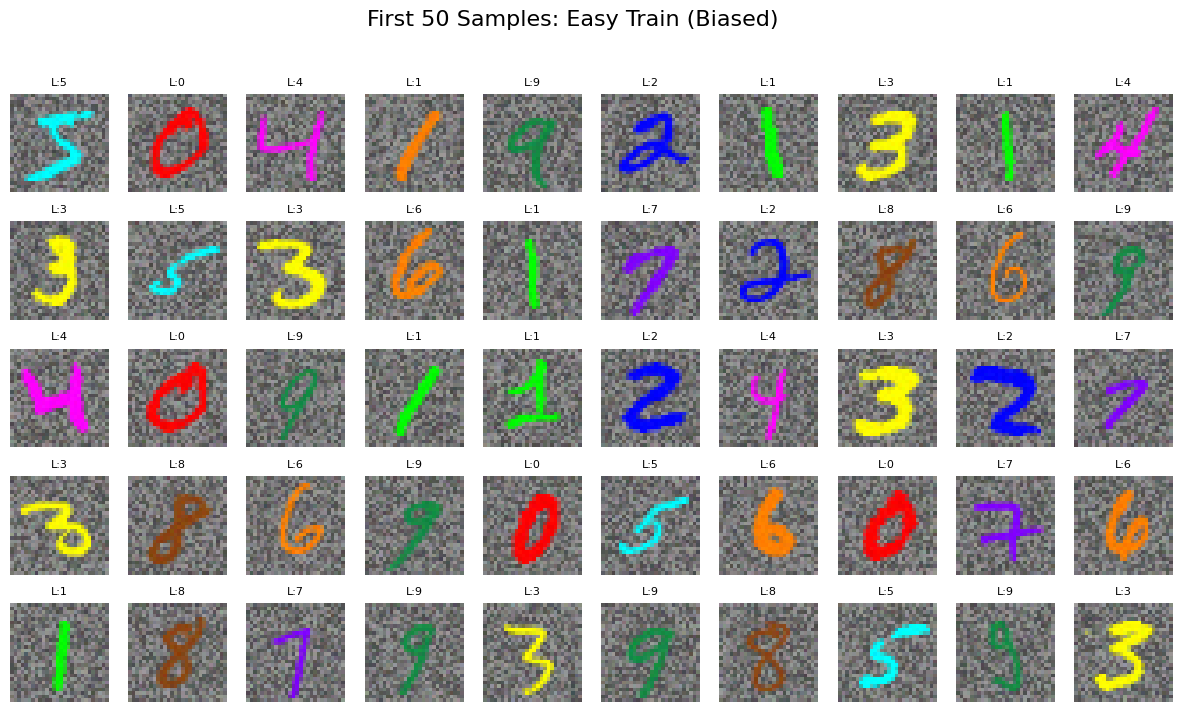

--- Verifying Easy Train (Counterfactuals) Set ---


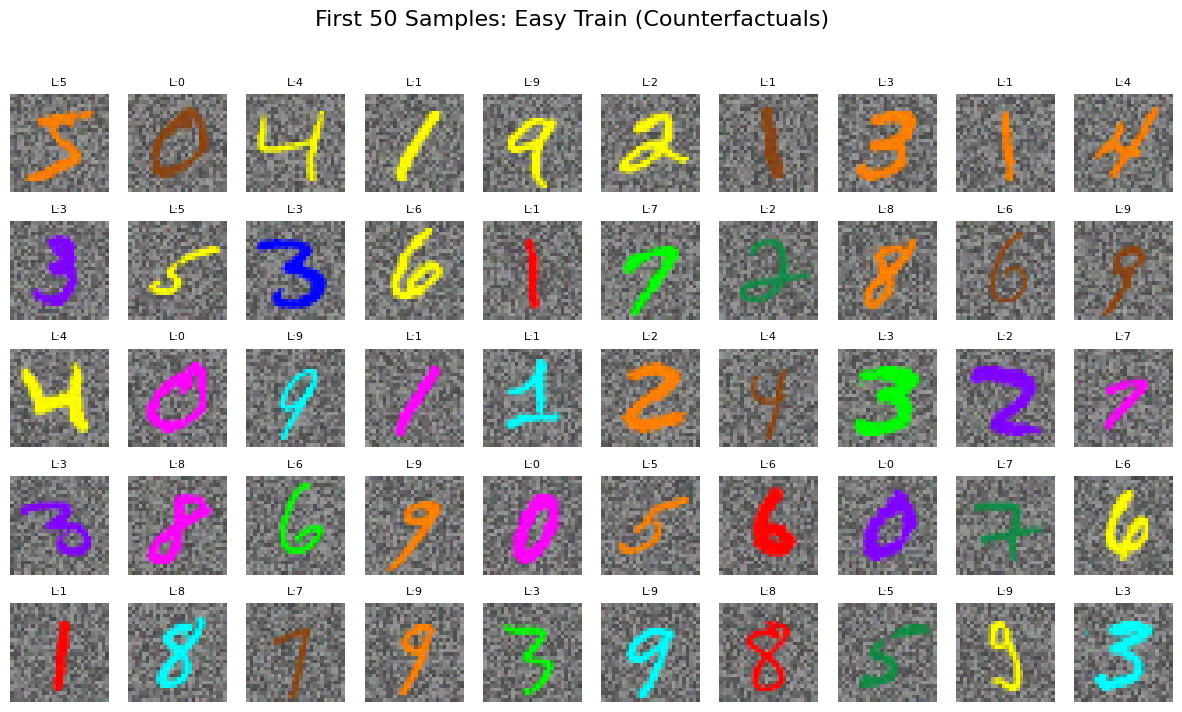

--- Verifying Hard Test (Lying) Set ---


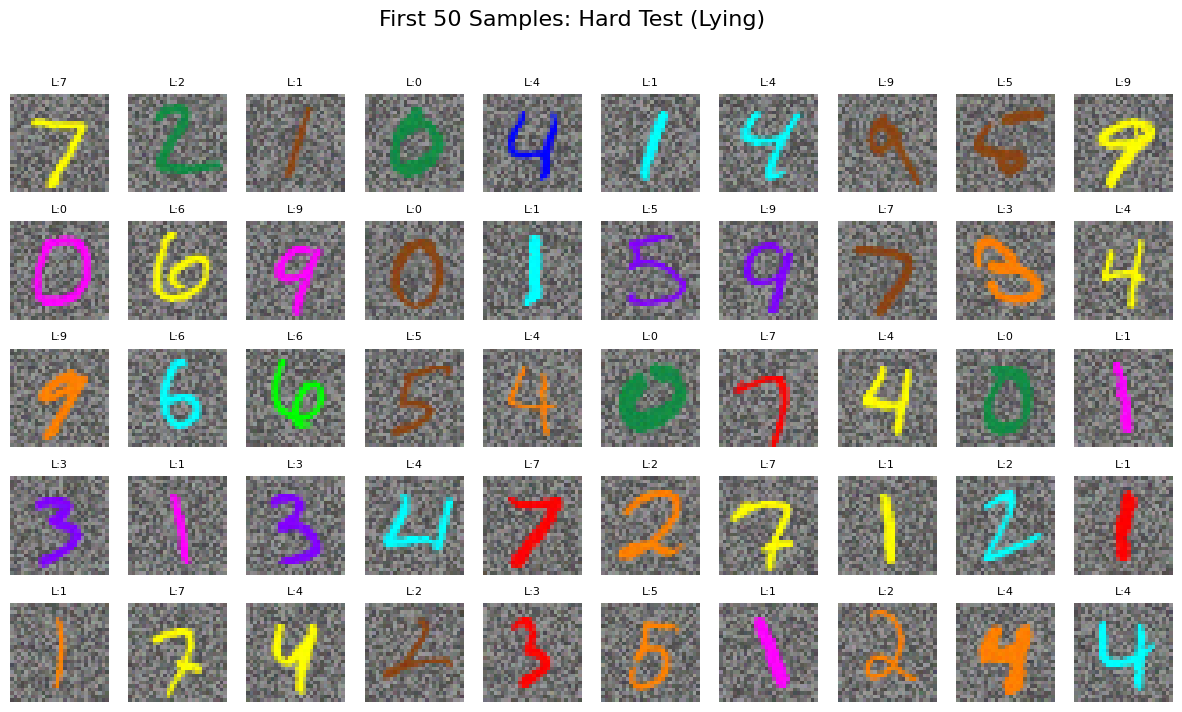

In [9]:
import matplotlib.pyplot as plt

def verify_bias(images, labels, set_name):
    print(f"--- Verifying {set_name} Set ---")
    plt.figure(figsize=(15, 8))
    for i in range(50):
        plt.subplot(5, 10, i+1)
        plt.imshow(images[i])
        # Display label and the color of the center pixel to confirm
        plt.title(f"L:{labels[i]}", fontsize=8)
        plt.axis('off')
    plt.suptitle(f"First 50 Samples: {set_name}", fontsize=16)
    plt.show()

# Run for both sets
verify_bias(x_train, y_train, "Easy Train (Biased)")
verify_bias(x_train_cf, y_train, "Easy Train (Counterfactuals)")
verify_bias(x_test, y_test, "Hard Test (Lying)")

In [ ]:
class ColoredMNISTCounterfactualDataset(Dataset):
    def __init__(self, images, images_cf, labels):
        self.images = torch.tensor(images, dtype=torch.float32) / 255.0
        self.images_cf = torch.tensor(images_cf, dtype=torch.float32) / 255.0
        self.labels = torch.tensor(labels, dtype=torch.long)

        self.images = self.images.permute(0, 3, 1, 2)
        self.images_cf = self.images_cf.permute(0, 3, 1, 2)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.images_cf[idx], self.labels[idx]

In [ ]:
class ColoredMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32) / 255.0
        self.labels = torch.tensor(labels, dtype=torch.long)

        # NHWC → NCHW
        self.images = self.images.permute(0, 3, 1, 2)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


In [ ]:
train_images_path = os.path.join(PROCESSED_PATH, 'train_images.npy')
train_images_cf_path = os.path.join(PROCESSED_PATH, 'train_images_cf.npy')
train_labels_path  = os.path.join(PROCESSED_PATH, 'train_labels.npy')

test_images_path   = os.path.join(PROCESSED_PATH, 'test_images.npy')
test_labels_path   = os.path.join(PROCESSED_PATH, 'test_labels.npy')

x_train = np.load(train_images_path)
x_train_cf = np.load(train_images_cf_path)
y_train = np.load(train_labels_path)

x_test = np.load(test_images_path)
y_test = np.load(test_labels_path)

train_dataset = ColoredMNISTCounterfactualDataset(x_train, x_train_cf, y_train )

test_dataset = ColoredMNISTDataset( x_test, y_test)